# 实验优化 🕵️‍♂️
* 使用 Tensorflow 搭建神经网络完成VPN流量的识别
* FIAT: 向前发送两个数据包之间的时间（平均值，最大值，最小值，标准方差）
* BIAT: 向后发送两个数据包之间的时间（平均值，最大值，最小值，标准方差）
* FLOWIAT: 形成数据流的两个数据包之间的时间（平均值，最大值，最小值，标准方差）
* ACTIVE: 时间量，在变成空闲之前的活跃时间
* IDLE: 时间量，在变成活跃之前的空闲时间

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

## 1. 加载数据

In [2]:
pd_data1 = pd.read_csv('data/vpn_data/15s.csv')
pd_data2 = pd.read_csv('data/vpn_data/60s.csv')

In [3]:
pd_data1.shape

(18758, 24)

In [4]:
pd_data2.shape

(15515, 24)

### 1.1 观察数据分布

In [6]:
def watch_datas(datas):
    plt.figure(figsize=(20,20))
    for i in range(len(datas.keys())-1):
        if i<= len(datas.keys()):
            key = datas.keys()[i]
            plt.subplot(6,4,i+1)
            plt.xlabel(key)
            plt.hist(datas[key],bins=20)
    plt.show()

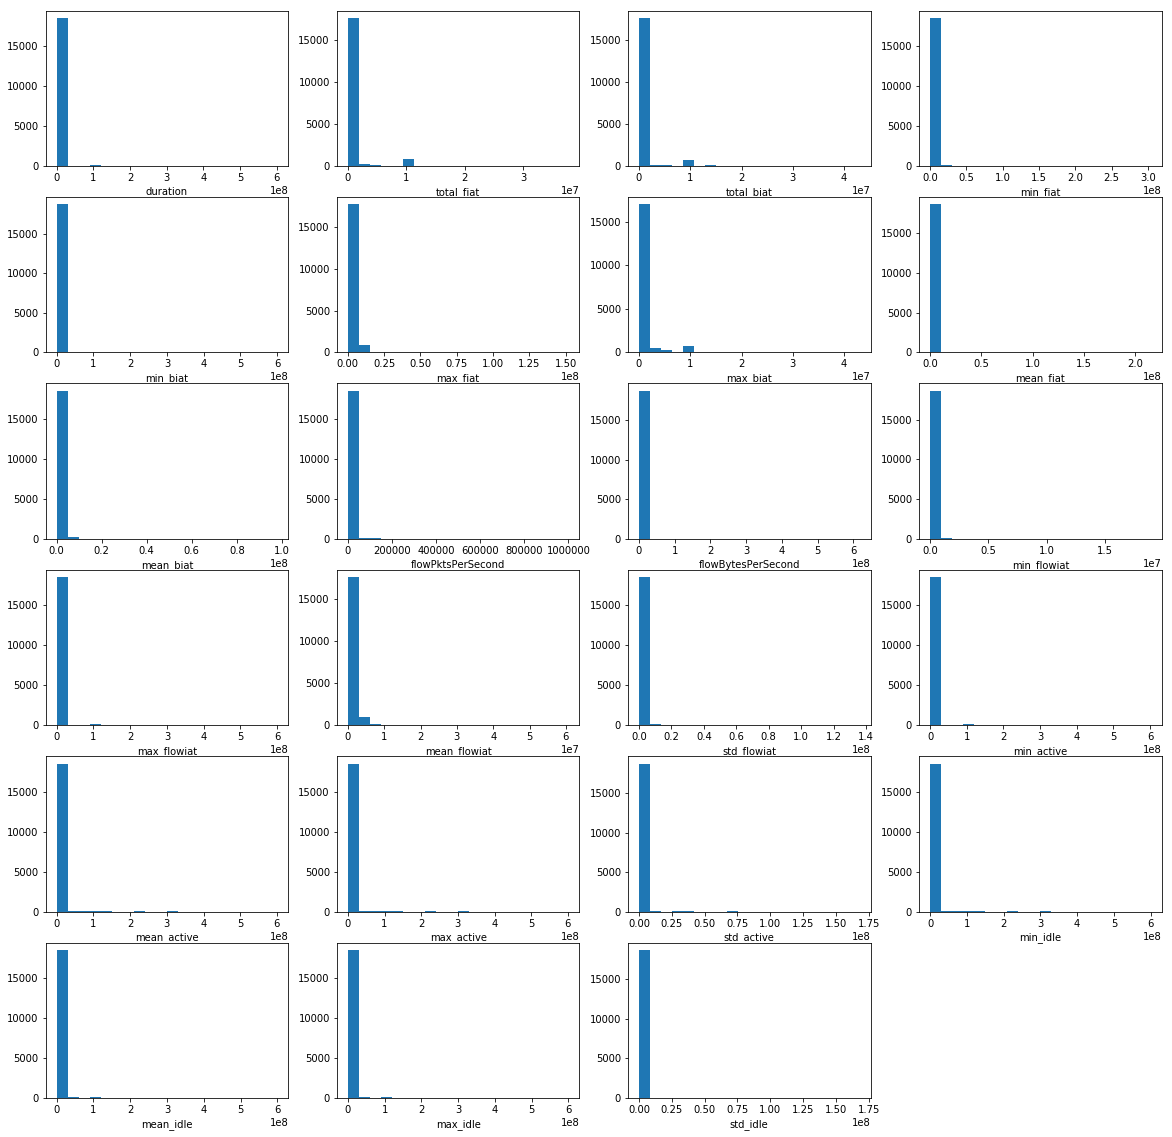

In [7]:
watch_datas(pd_data1)

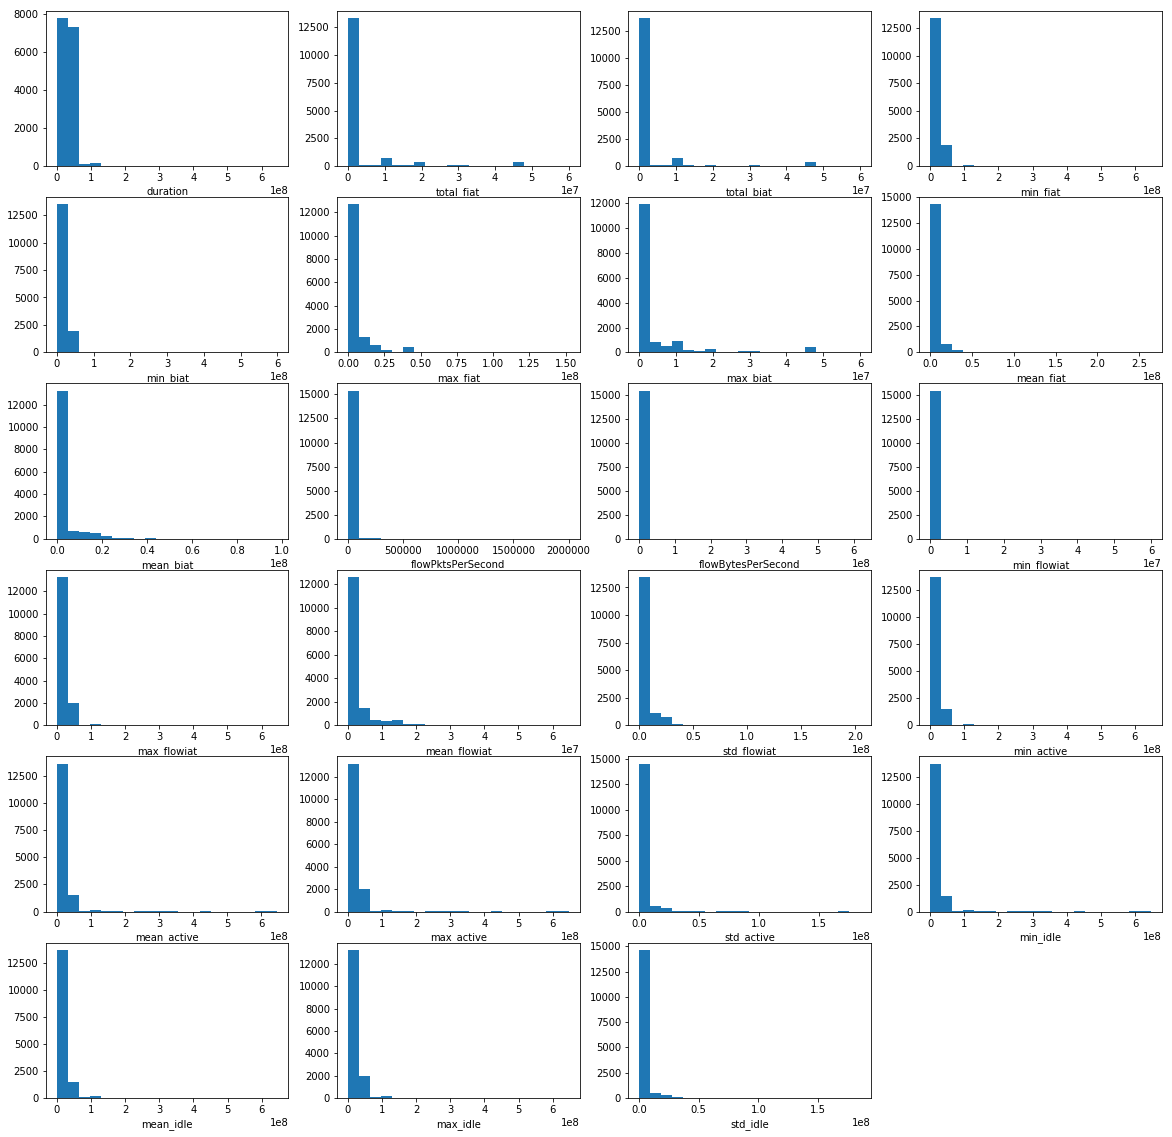

In [8]:
watch_datas(pd_data2)

### 1.2 合并数据

In [9]:
pd_data = pd.concat([pd_data1, pd_data2], axis=0)
pd_data.shape

(34273, 24)

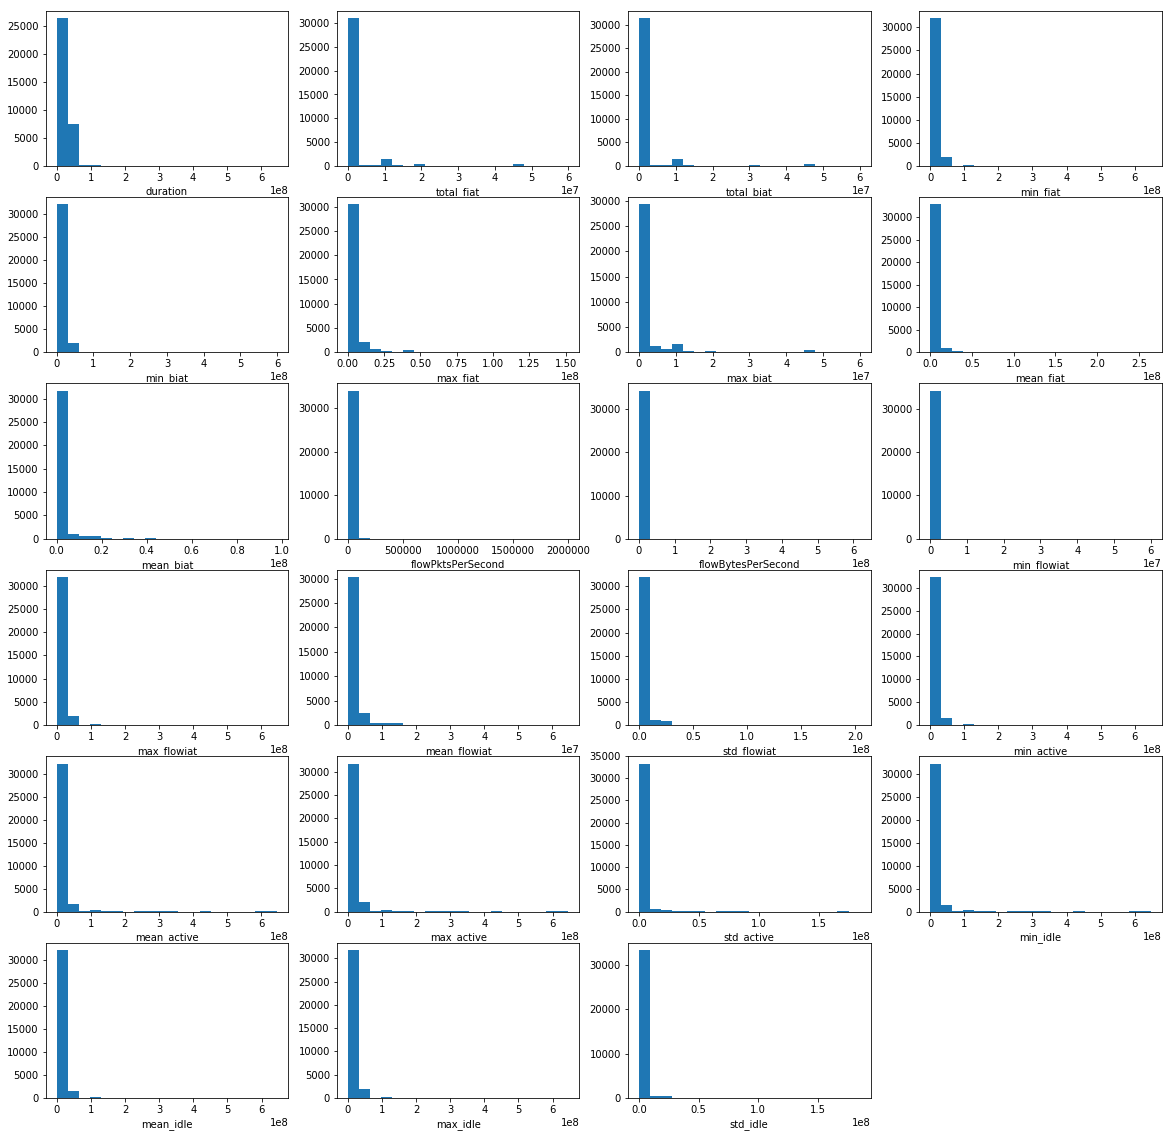

In [10]:
watch_datas(pd_data)

### 1.3 处理数据
* 数据打乱
* 制作标签
* 数据归一
* 数据集划分

In [14]:
def create_labels(labels):
    return np.where(labels=='VPN',1,0)

def create_datas(pd_data):
    shuffled_datas = pd_data.sample(frac=1.0)
    labels = create_labels(shuffled_datas.label.values)
    norm_datas = shuffled_datas.drop('label', axis=1)
    norm_datas_mean = norm_datas.mean(0)
    norm_datas_std = norm_datas.std(0)
    norm_datas = (norm_datas - norm_datas_mean) / norm_datas_std
    numpy_datas = norm_datas.values
    test_x, test_y = numpy_datas[0:2000], labels[0:2000]
    train_x, train_y = numpy_datas[2000:], labels[2000:]
    print("测试数据与标签：{} | {}".format(test_x.shape, test_y.shape))
    print("训练数据与标签：{} | {}".format(train_x.shape, train_y.shape))
    return train_x, train_y, test_x, test_y

#k_data = pd_data[~pd_data.isin([-1])].dropna()
train_x, train_y, test_x, test_y = create_datas(pd_data)

测试数据与标签：(2000, 23) | (2000,)
训练数据与标签：(32273, 23) | (32273,)


## 2. 使用 Tensorflow 建立模型

In [17]:
epochs = 400
batch_size = 256

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu',input_shape=(23,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

In [18]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1536      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### 2.1 开始训练

In [19]:
log = model.fit(train_x, 
                train_y, 
                batch_size=batch_size, 
                epochs=epochs, 
                validation_split=0.2)

Train on 25818 samples, validate on 6455 samples
Epoch 1/400
25818/25818 [==============================] - 1s 53us/sample - loss: 0.6817 - accuracy: 0.5540 - val_loss: 0.6572 - val_accuracy: 0.5930
Epoch 2/400
25818/25818 [==============================] - 0s 14us/sample - loss: 0.6655 - accuracy: 0.5830 - val_loss: 0.6519 - val_accuracy: 0.6081
Epoch 3/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.6586 - accuracy: 0.5965 - val_loss: 0.6476 - val_accuracy: 0.6174
Epoch 4/400
25818/25818 [==============================] - 0s 14us/sample - loss: 0.6497 - accuracy: 0.6086 - val_loss: 0.6436 - val_accuracy: 0.6181
Epoch 5/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.6501 - accuracy: 0.6103 - val_loss: 0.6401 - val_accuracy: 0.6373
Epoch 6/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.6458 - accuracy: 0.6173 - val_loss: 0.6358 - val_accuracy: 0.6332
Epoch 7/400
25818/25818 [==========================

Epoch 55/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5840 - accuracy: 0.6712 - val_loss: 0.5702 - val_accuracy: 0.6717
Epoch 56/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5841 - accuracy: 0.6725 - val_loss: 0.5703 - val_accuracy: 0.6802
Epoch 57/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5830 - accuracy: 0.6696 - val_loss: 0.5665 - val_accuracy: 0.6861
Epoch 58/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5831 - accuracy: 0.6748 - val_loss: 0.5674 - val_accuracy: 0.6855
Epoch 59/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5803 - accuracy: 0.6736 - val_loss: 0.5688 - val_accuracy: 0.6846
Epoch 60/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5818 - accuracy: 0.6744 - val_loss: 0.5667 - val_accuracy: 0.6829
Epoch 61/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5823 - ac

Epoch 163/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5590 - accuracy: 0.6940 - val_loss: 0.5483 - val_accuracy: 0.7009
Epoch 164/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5598 - accuracy: 0.6923 - val_loss: 0.5397 - val_accuracy: 0.7086
Epoch 165/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5592 - accuracy: 0.6908 - val_loss: 0.5441 - val_accuracy: 0.7057
Epoch 166/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5614 - accuracy: 0.6880 - val_loss: 0.5429 - val_accuracy: 0.7024
Epoch 167/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5572 - accuracy: 0.6949 - val_loss: 0.5464 - val_accuracy: 0.6993
Epoch 168/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5571 - accuracy: 0.6929 - val_loss: 0.5478 - val_accuracy: 0.7050
Epoch 169/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.55

Epoch 217/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5542 - accuracy: 0.6949 - val_loss: 0.5362 - val_accuracy: 0.7198
Epoch 218/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5525 - accuracy: 0.6987 - val_loss: 0.5393 - val_accuracy: 0.7038
Epoch 219/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5509 - accuracy: 0.6973 - val_loss: 0.5381 - val_accuracy: 0.7146
Epoch 220/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5553 - accuracy: 0.6966 - val_loss: 0.5392 - val_accuracy: 0.7055
Epoch 221/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5536 - accuracy: 0.6982 - val_loss: 0.5392 - val_accuracy: 0.7044
Epoch 222/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5538 - accuracy: 0.6967 - val_loss: 0.5380 - val_accuracy: 0.7060
Epoch 223/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.55

Epoch 271/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5506 - accuracy: 0.7021 - val_loss: 0.5326 - val_accuracy: 0.7168
Epoch 272/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5512 - accuracy: 0.6991 - val_loss: 0.5338 - val_accuracy: 0.7165
Epoch 273/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5520 - accuracy: 0.6981 - val_loss: 0.5310 - val_accuracy: 0.7134
Epoch 274/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5531 - accuracy: 0.6989 - val_loss: 0.5324 - val_accuracy: 0.7126
Epoch 275/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5585 - accuracy: 0.6980 - val_loss: 0.5349 - val_accuracy: 0.7137
Epoch 276/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5513 - accuracy: 0.6998 - val_loss: 0.5305 - val_accuracy: 0.7160
Epoch 277/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.55

Epoch 325/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5486 - accuracy: 0.7015 - val_loss: 0.5335 - val_accuracy: 0.7215
Epoch 326/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5468 - accuracy: 0.7023 - val_loss: 0.5346 - val_accuracy: 0.7089
Epoch 327/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5498 - accuracy: 0.7013 - val_loss: 0.5300 - val_accuracy: 0.7148
Epoch 328/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5452 - accuracy: 0.7052 - val_loss: 0.5312 - val_accuracy: 0.7111
Epoch 329/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5488 - accuracy: 0.7019 - val_loss: 0.5339 - val_accuracy: 0.7108
Epoch 330/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5537 - accuracy: 0.7011 - val_loss: 0.5324 - val_accuracy: 0.7055
Epoch 331/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.54

Epoch 379/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5507 - accuracy: 0.7053 - val_loss: 0.5258 - val_accuracy: 0.7165
Epoch 380/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5433 - accuracy: 0.7038 - val_loss: 0.5271 - val_accuracy: 0.7198
Epoch 381/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5434 - accuracy: 0.7064 - val_loss: 0.5271 - val_accuracy: 0.7196
Epoch 382/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5438 - accuracy: 0.7020 - val_loss: 0.5295 - val_accuracy: 0.7159
Epoch 383/400
25818/25818 [==============================] - 0s 13us/sample - loss: 0.5422 - accuracy: 0.7078 - val_loss: 0.5301 - val_accuracy: 0.7154
Epoch 384/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.5421 - accuracy: 0.7047 - val_loss: 0.5313 - val_accuracy: 0.7149
Epoch 385/400
25818/25818 [==============================] - 0s 12us/sample - loss: 0.54

### 2.2 训练评估

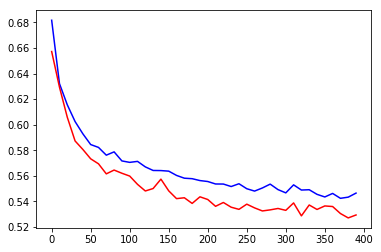

In [20]:
plt_x = log.epoch[::10]
plt_y1 = log.history['loss'][::10]
plt_y2 = log.history['val_loss'][::10]
plt.plot(plt_x, plt_y1, 'b-')
plt.plot(plt_x, plt_y2, 'r-')
plt.show()

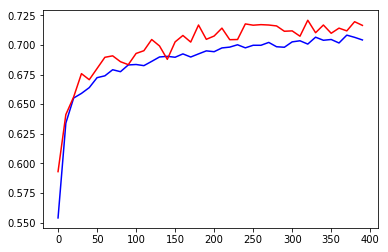

In [21]:
plt_y3 = log.history['accuracy'][::10]
plt_y4 = log.history['val_accuracy'][::10]
plt.plot(plt_x, plt_y3, 'b-')
plt.plot(plt_x, plt_y4, 'r-')

In [22]:
model.evaluate(test_x, test_y, verbose=2)

2000/1 - 0s - loss: 0.5292 - accuracy: 0.7235


[0.5224826951026916, 0.7235]